# **Import Library**

In [1]:
# pip install tensorflow

In [2]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import numpy as np
from matplotlib.colors import ListedColormap
from rasterio.mask import mask
from shapely.geometry import Point, box
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model, save_model
from rasterio.transform import from_origin
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
import os

## **Tiff band information**

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 99999.0, 'width': 3781, 'height': 4451, 'count': 14, 'crs': CRS.from_epsg(32643), 'transform': Affine(50.0, 0.0, 607475.0,
       0.0, -50.0, 1743025.0)}


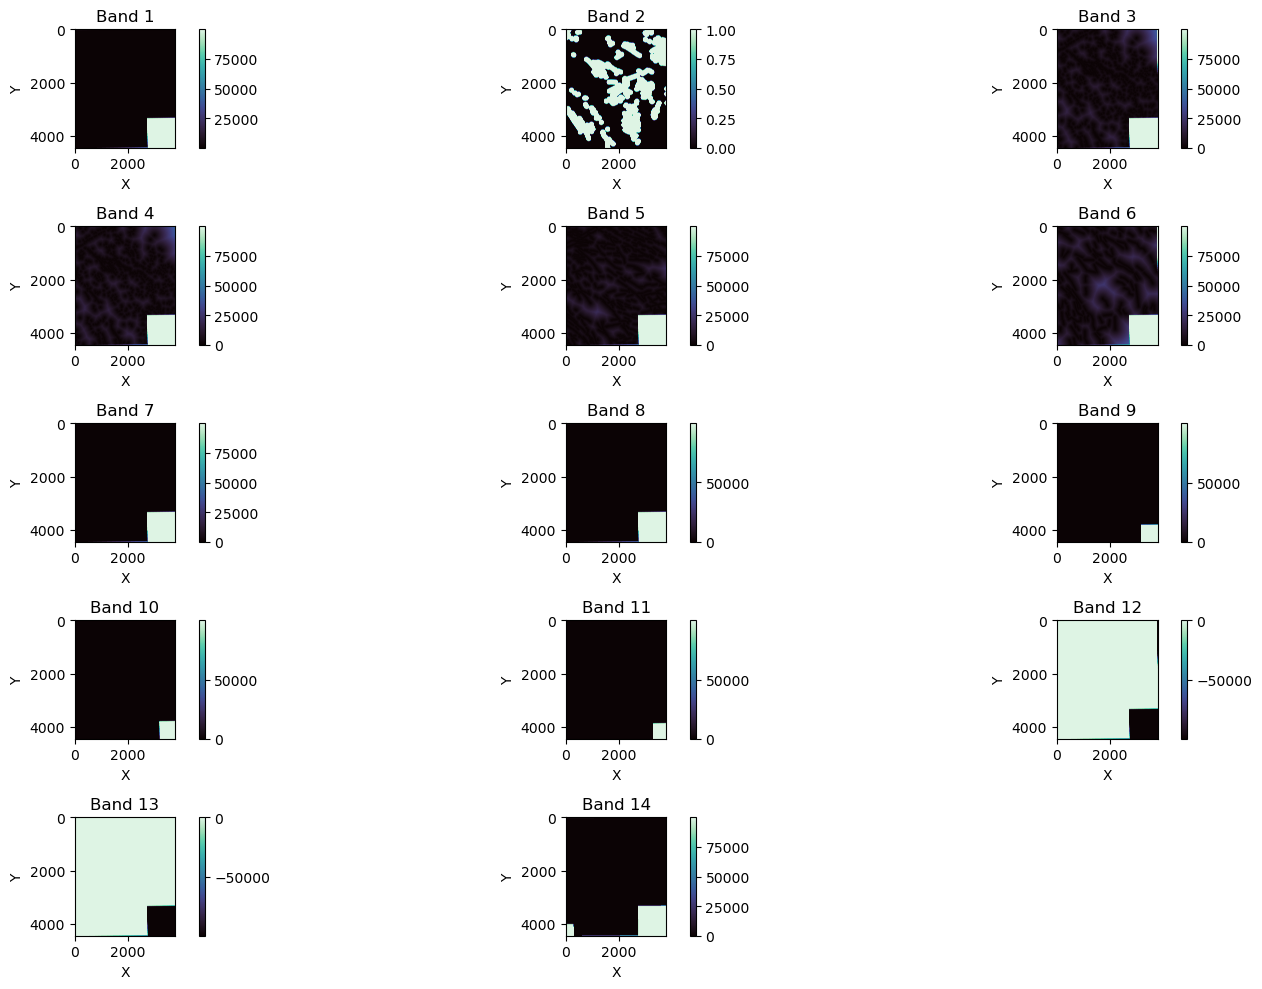

In [3]:
# Path to TIFF file
tiff_path = r'../CNN/cu_input.tiff'

# Open the TIFF file
with rasterio.open(tiff_path) as dataset:
    # Read the first band (assuming single-band grayscale image)
    band1 = dataset.read(1)
    band2 = dataset.read(2)
    band3 = dataset.read(3)
    band4 = dataset.read(4)
    band5 = dataset.read(5)
    band6 = dataset.read(6)
    band7 = dataset.read(7)
    band8 = dataset.read(8)
    band9 = dataset.read(9)
    band10 = dataset.read(10)
    band11 = dataset.read(11)
    band12 = dataset.read(12)
    band13 = dataset.read(13)
    band14 = dataset.read(14)
    # Get the metadata
    meta = dataset.meta

    # Print metadata
    print(meta)
    
    # List of bands
    bands = [band1, band2, band3, band4, band5, band6, band7, band8, band9, band10, band11, band12, band13, band14]
    
    # Create figure and axes
    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 10))
    
    # Flatten axes array for easy iteration
    axes = axes.flatten()
     
    # Plot each band
    for i, band in enumerate(bands):
        im = axes[i].imshow(band, cmap='mako')
        axes[i].set_title(f'Band {i+1}')
        axes[i].set_xlabel('X')
        axes[i].set_ylabel('Y')
        fig.colorbar(im, ax=axes[i])
    
    # Turn off unused subplots
    for j in range(len(bands), len(axes)):
        axes[j].axis('off')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()



## **Deposit and non-deposit points of AU**

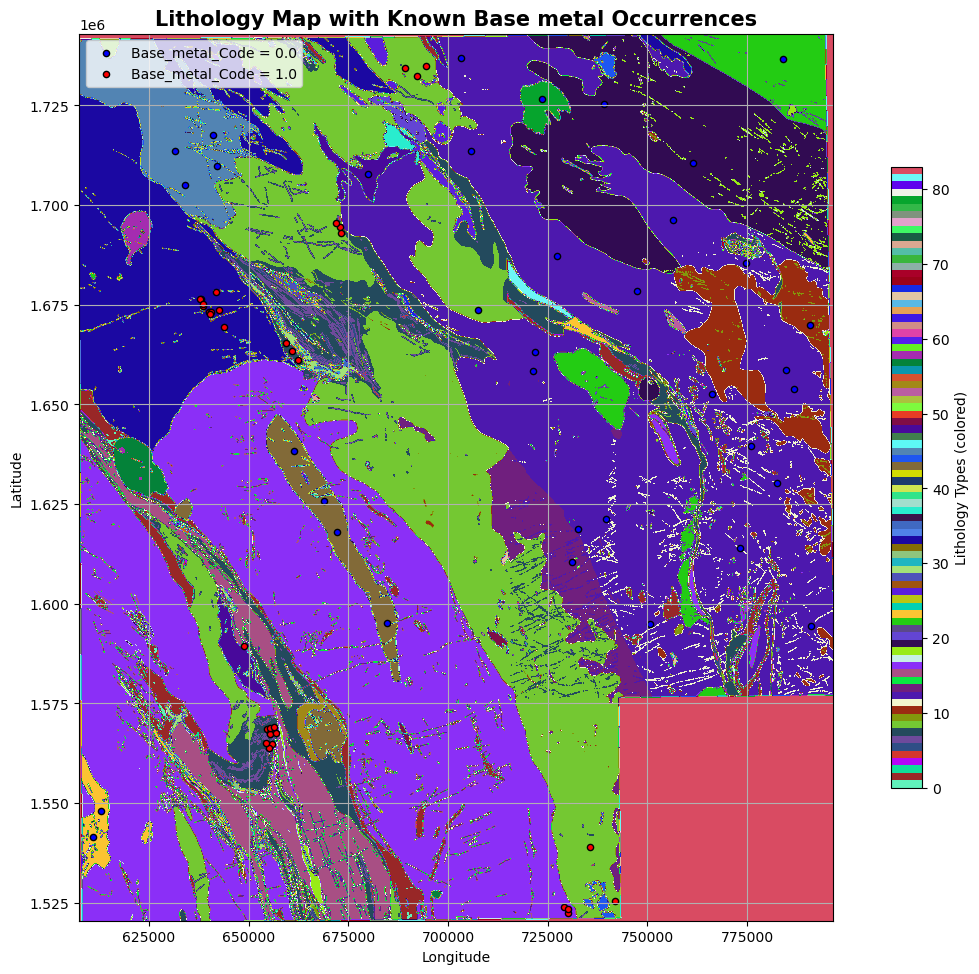

In [4]:
# File paths
tiff_file = r'../CNN/cu_input.tiff'
shapefile = r'../CNN/BM_N_BM_new.shp'

# Load the lithology band (first band)
with rasterio.open(tiff_file) as src:
    litho_data = src.read(1)  # Band 1 is lithology
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# Load shapefile and filter only geometry and Gold_Code
gdf = gpd.read_file(shapefile)[['geometry', 'Base_M']]

# Create a categorical colormap for lithologies
unique_lithologies = np.unique(litho_data[litho_data > 0])  # Remove 0 (assumed nodata)
num_classes = len(unique_lithologies)

# Generate a random color map with distinct colors
np.random.seed(42)
cmap = ListedColormap(np.random.rand(num_classes, 3))

# Prepare a mapping from actual lithology value to color index
litho_index_map = {val: idx for idx, val in enumerate(unique_lithologies)}
mapped_litho = np.zeros_like(litho_data, dtype=int)
for val, idx in litho_index_map.items():
    mapped_litho[litho_data == val] = idx

# Color mapping for Gold_Code (binary)
color_map = {0: 'blue', 1: 'red'}
gdf['color'] = gdf['Base_M'].map(color_map)

# Plot
plt.figure(figsize=(12, 10))

# Show lithology raster with categorical colors
plt.imshow(mapped_litho, cmap=cmap, extent=extent)
plt.colorbar(label='Lithology Types (colored)', shrink=0.7)

# Overlay Gold_Code points
for val, group in gdf.groupby('Base_M'):
    group.plot(ax=plt.gca(), facecolor=group['color'].iloc[0], edgecolor='black', label=f'Base_metal_Code = {val}', markersize=20)

plt.title('Lithology Map with Known Base metal Occurrences', fontsize=15, fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## **Patch extraction from tiff**

In [5]:
patch_size = 32
buffer_radius = 800  #buffer

def extract_patches_from_shapefile(tiff_file, shapefile, patch_size):
    patches = []
    labels = []
    patch_count = 0

    with rasterio.open(tiff_file) as dataset:
        shapes = gpd.read_file(shapefile)
         # Step 1: Set CRS if missing
        if shapes.crs is None:
            shapes.set_crs(dataset.crs, inplace=True)  # assume TIFF CRS is correct
    
        # Step 2: Reproject to match raster CRS
        shapes = shapes.to_crs(dataset.crs)


        raster_geom = box(*dataset.bounds)  # Create polygon from raster bounds

        for geom_index, row in shapes.iterrows():
            geom = row.geometry
            label = row['Base_M']

            # Check if buffered geometry intersects raster bounds
            buffered_geom = geom.buffer(buffer_radius)
            if not raster_geom.intersects(buffered_geom):
                print(f"Skipping geometry {geom_index} - outside raster bounds")
                continue

            try:
                out_image, out_transform = mask(dataset, [buffered_geom], crop=True)
                out_image = out_image.transpose((1, 2, 0))

                height, width, num_layers = out_image.shape
                print(f"Geometry {geom_index + 1}/{len(shapes)}: {height}x{width}, Label={label}")

                for i in range(0, height, patch_size):
                    for j in range(0, width, patch_size):
                        patch = out_image[i:i+patch_size, j:j+patch_size]
                        if patch.shape == (patch_size, patch_size, num_layers):
                            patches.append(patch)
                            labels.append(label)
                            patch_count += 1
            except Exception as e:
                print(f"Failed to extract patch for geometry {geom_index}: {e}")

    print(f"Total patches created: {patch_count}")
    return np.array(patches), np.array(labels)

# Run extraction
print("Extracting patches from base metal shapefile...")
X, y = extract_patches_from_shapefile(tiff_file, shapefile, patch_size)

print(f"Total patches: {len(X)}")
print(f"Positive: {np.sum(y == 1)}, Negative: {np.sum(y == 0)}")


Extracting patches from base metal shapefile...
Geometry 1/71: 33x33, Label=1.0
Geometry 2/71: 33x33, Label=1.0
Geometry 3/71: 33x33, Label=1.0
Geometry 4/71: 33x33, Label=1.0
Geometry 5/71: 33x33, Label=1.0
Geometry 6/71: 33x33, Label=1.0
Geometry 7/71: 33x33, Label=1.0
Geometry 8/71: 33x33, Label=1.0
Geometry 9/71: 33x33, Label=1.0
Geometry 10/71: 33x33, Label=1.0
Geometry 11/71: 33x33, Label=1.0
Geometry 12/71: 33x33, Label=1.0
Geometry 13/71: 33x33, Label=1.0
Geometry 14/71: 33x33, Label=1.0
Geometry 15/71: 33x33, Label=1.0
Geometry 16/71: 33x33, Label=1.0
Geometry 17/71: 33x33, Label=1.0
Geometry 18/71: 33x33, Label=1.0
Geometry 19/71: 33x33, Label=1.0
Geometry 20/71: 33x33, Label=0.0
Geometry 21/71: 33x33, Label=0.0
Geometry 22/71: 33x33, Label=0.0
Geometry 23/71: 33x33, Label=0.0
Geometry 24/71: 33x33, Label=0.0
Geometry 25/71: 33x33, Label=0.0
Geometry 26/71: 33x33, Label=1.0
Geometry 27/71: 33x33, Label=0.0
Geometry 28/71: 33x33, Label=0.0
Geometry 29/71: 33x33, Label=1.0
Geom

## **Data Preparation**

In [6]:
# Split data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
X.shape

(71, 32, 32, 14)

In [8]:
y.shape

(71,)

In [9]:
X_train.shape

(56, 32, 32, 14)

In [10]:
y_train.shape

(56,)

In [11]:
X_val.shape

(15, 32, 32, 14)

In [12]:
y_val.shape

(15,)

## **Model Training**

In [13]:
# Fix labels
y_train = np.clip(y_train.astype('int'), 0, 1)
y_val = np.clip(y_val.astype('int'), 0, 1)

# Normalize
X_train = X_train.astype('float32') / 100.0
X_val = X_val.astype('float32') / 100.0

# Clean NaNs/Infs
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)

# Model
model = Sequential([
    Input(shape=(32, 32, 14)),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile
from tensorflow.keras.losses import BinaryCrossentropy
loss_fn = BinaryCrossentropy(from_logits=False)

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss=loss_fn,
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy',      # Stop based on validation accuracy
    patience=10,                 # Number of epochs with no improvement
    restore_best_weights=True,  # Restore best weights at the end
    verbose=1,
    mode='max'                  # Because higher val_accuracy is better
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Fit the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=70,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Save the trained model
model.save("final_mineral_model.h5")


Epoch 1/70


C:\Users\PGRS_GID\AppData\Local\Temp\ipykernel_10980\2065469628.py:2: RuntimeWarning: invalid value encountered in cast
  y_train = np.clip(y_train.astype('int'), 0, 1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - accuracy: 0.4881 - loss: 60.7116 - val_accuracy: 0.6000 - val_loss: 58.4787 - learning_rate: 5.0000e-04
Epoch 2/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.3869 - loss: 71.0028 - val_accuracy: 0.4000 - val_loss: 70.9532 - learning_rate: 5.0000e-04
Epoch 3/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5670 - loss: 41.7061 - val_accuracy: 0.3333 - val_loss: 49.5662 - learning_rate: 5.0000e-04
Epoch 4/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.5997 - loss: 19.3950 - val_accuracy: 0.6000 - val_loss: 30.5072 - learning_rate: 5.0000e-04
Epoch 5/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.4643 - loss: 37.0216 - val_accuracy: 0.5333 - val_loss: 17.7255 - learning_rate: 5.0000e-04
Epoch 6/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.5104 - loss: 14.9479 - val_accuracy: 0.4000 - val_loss: 39.3835 - learning_rate: 5.0000e-04
Epoch 7/70
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.5908 - loss

## **Confusion Matrix & Classification Report**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
              precision    recall  f1-score   support

           0       0.67      0.33      0.44         6
           1       0.67      0.89      0.76         9

    accuracy                           0.67        15
   macro avg       0.67      0.61      0.60        15
weighted avg       0.67      0.67      0.63        15

[[2 4]
 [1 8]]


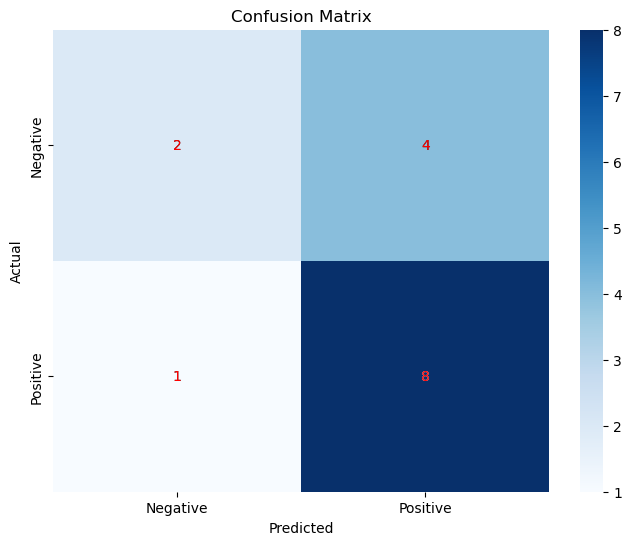

In [14]:
# Make predictions
y_pred_prob = model.predict(X_val)

# Convert probabilities to binary predictions (0 or 1) using a threshold of 0.5
y_pred = (y_pred_prob > 0.5).astype("int32")


# Print classification report
print(classification_report(y_val, y_pred))

# Print confusion matrix
print(confusion_matrix(y_val, y_pred))


# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
# Loop over data dimensions and create text annotations
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        plt.text(j + 0.5, i + 0.5, f'{conf_matrix[i, j]}', ha='center', va='center', color='red')
       
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



## **Plotting Training and Validation Loss and Accuracy**

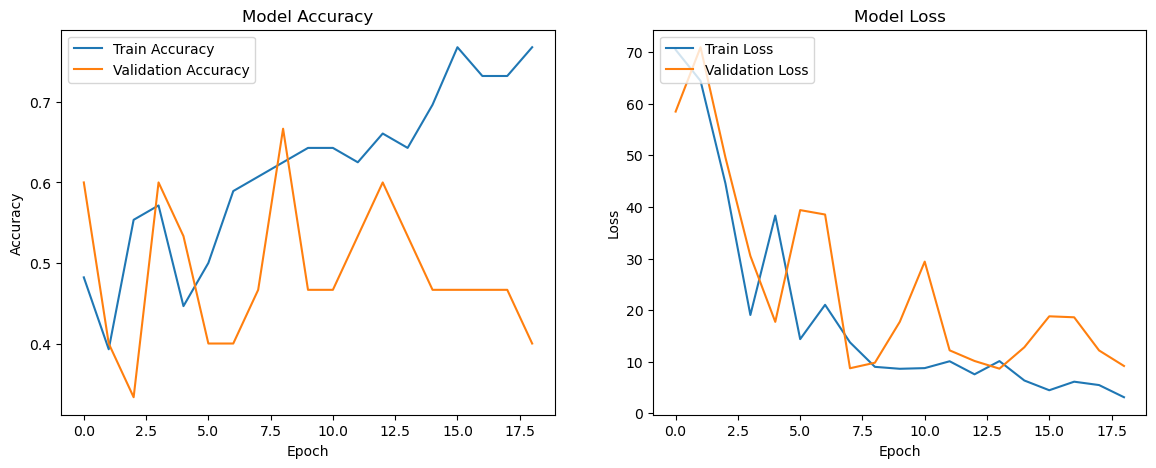

In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()


## **Save the Model**

In [17]:
# Assuming 'model' is trained Keras model
model.save('cnn_base_metal_67.keras')  # Save the entire model


## **Prediction Map**

C:\Users\PGRS_GID\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


513/513 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


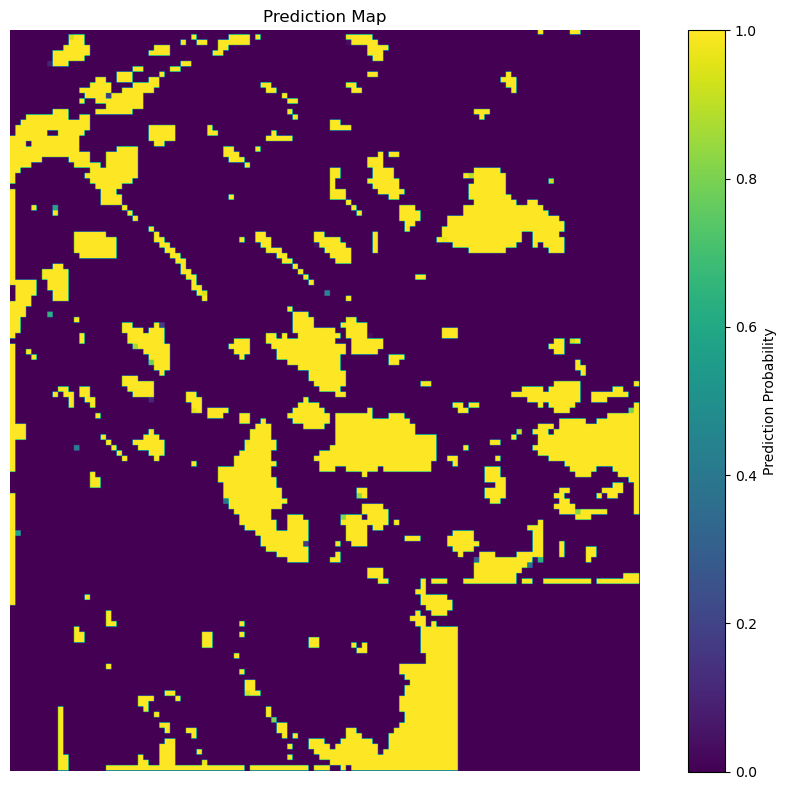

In [18]:
# Load the raster data
raster_path = r'cu_input.tiff'
with rasterio.open(raster_path) as src:
    raster_data = src.read().transpose((1, 2, 0))  # (height, width, bands)
    height, width, bands = raster_data.shape
    src_transform = src.transform
    src_crs = src.crs

# Load the pre-trained CNN model
model_path = r'cnn_base_metal_67.keras'
model = load_model(model_path)

# Define patch size
patch_size = 32  # Must match training

# Prepare data for prediction
new_data_patches = []
patch_coordinates = []

for i in range(0, height, patch_size):
    for j in range(0, width, patch_size):
        patch = raster_data[i:i+patch_size, j:j+patch_size]
        if patch.shape == (patch_size, patch_size, bands):
            new_data_patches.append(patch)
            patch_coordinates.append((i, j))

new_data_patches = np.array(new_data_patches)
new_data_patches = new_data_patches.reshape((new_data_patches.shape[0], patch_size, patch_size, bands))

# Predict probabilities
predictions = model.predict(new_data_patches).flatten()  # Output between 0–1

# Create continuous prediction map
prediction_map = np.zeros((height, width))

for idx, (i, j) in enumerate(patch_coordinates):
    prediction_map[i:i+patch_size, j:j+patch_size] = predictions[idx]

# --------- Visualization ----------
plt.figure(figsize=(10, 8))

# Foreground: prediction overlay (0 to 1 probability)
plt.imshow(prediction_map, cmap='viridis', alpha=1.0, vmin=0, vmax=1)
plt.colorbar(label='Prediction Probability')
plt.title('Prediction Map')
plt.axis('off')
plt.tight_layout()
plt.show()


## **Save the prediction map**

In [20]:
# Use metadata from the input file
with rasterio.open('cu_input.tiff') as src:
    profile = src.profile.copy()
    profile.update(
        dtype='float32',
        count=1,
        nodata=99999  
    )
    transform = src.transform
    crs = src.crs

# Save prediction_map
with rasterio.open('prediction_map_67.tif', 'w', **profile) as dst:
    dst.write(prediction_map.astype('float32'), 1)
